In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from gaussian_mixture_sampler import GaussianMixtureSampler
from bayes_adaptive_fitter import BayesAdaptor 
from adaptive_tools import *

# Example for Bayesian adaptive method

This notebook demostrates the functionality of the `BayesAdaptor` class, which provides all of the tools necessary for adaptive Bayesian estimation of free energies. `BayesAdaptor` takes state counts from multinomial mixture sampling, performs Bayesian estimation of the free energies, and generates biasing potentials for the next round of mixture sampling to ensure subsequent data is maximally informative.

### Hyperparameters for adaptive method 

In [2]:
# Defining the prior information.
prior = 'gaussian'    # Choice is between 'gaussian' and 'cauchy'
spread = 2.0
location = -5.0

# The zeta sampling scheme
method = 'map'  # Use the MAP estimate of the free energy to select the next biasing potential
logistic = False

# Number of adaptive cycles
ncycles = 50

# Number of iterations and data thinning from Gaussian mixture sampling
niterations = 250
save_freq = 50
print 'Total number of counts per cycle:', niterations/save_freq

# Emcee parameters for sampling from the posterior distribution of free energies
nmoves = 1000
nwalkers = 20
burnin = 100

Total number of counts per cycle: 5


## Adaptive estimate for 2 state system
For the purpose of demonstration, the target free energy (the free energy of the second state relative to the first state) is generated from the prior distribution. That free energy is then used to generate the standard deviation of the two Gaussian distributions that are sampled with `GaussianMixtureSwapper`.

In [3]:
# Generating the target free energy from the prior
f_true = -np.absolute(gen_free_energy(prior, spread, location, size=1))
sigmas = gen_sigmas(1.0, f_true)
print 'Sigmas:', sigmas
print 'Target:', f_true[0]

Sigmas: [   1.          442.38837434]
Target: -6.09218817126


In [4]:
# The initial biasing potential and counts
zetas = [[0.0, gen_free_energy(prior, spread, location, size=1)[0]]]
counts = []

# Pre-assigment for data collection
map_estimate = []
median = []
lowerq = []
upperq = []
for i in range(ncycles):
    # Sample from mixture
    sampler = GaussianMixtureSampler(sigmas=sigmas, zetas=zetas[i])
    sampler.sample_mixture(niterations=niterations, save_freq=save_freq)
    counts.append(sampler.state_counter)
    # Sample from the posterior
    adaptor = BayesAdaptor(zetas=np.array(zetas), counts=np.array(counts), prior=prior, spread=spread, location=location)
    adaptor.sample_posterior(nwalkers=nwalkers, nmoves=nmoves)
    # Sample a new biasing potential
    zetas.append([0, adaptor.gen_biases(method=method, logistic=logistic)[0]])
    # Collect data
    m = np.percentile(adaptor.flat_samples, 50)
    mp = adaptor.map_estimator(f_guess=np.hstack((0.0, m)))
    map_estimate.append(mp)
    median.append(m)
    lowerq.append(np.percentile(adaptor.flat_samples, 97.5))
    upperq.append(np.percentile(adaptor.flat_samples, 2.5))

### Plotting results
Viewing the median (thick line), true free energy (dotted line), and 95% credible region (light color).

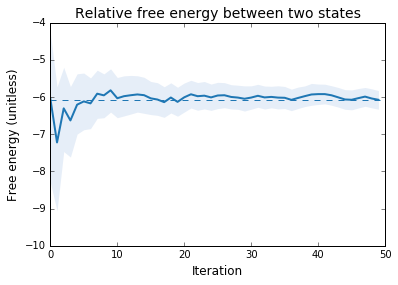

In [5]:
x = range(len(median))
color = 0
plt.clf()
plt.plot(x, median, color=tableau4[color], lw=2)
plt.axhline(y = f_true, color=tableau4[color], ls='--', lw=1)
plt.fill_between(x,lowerq, upperq, facecolor=tableau4_light[color], linewidth=0, alpha=0.3, interpolate=True)
plt.title('Relative free energy between two states', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Free energy (unitless)', fontsize=12)
plt.show()

## Adaptive estimate for 5 state system
In this case, there are 4 free energies of interest, as they are all relative to the free energy of the first state. As above, the 'states' are Gaussian distributions with the same mean (location), but vary in standard deviation.  

In [6]:
# Generating the target free energy from the prior
f_true = -np.absolute(gen_free_energy(prior, spread, location, size=4))
sigmas = gen_sigmas(1.0, f_true)
print 'Sigmas:',sigmas
print 'Target:', f_true

Sigmas: [   1.           30.73193841   73.59831845  901.29120701   70.18822094]
Target: [-3.42530245 -4.29862218 -6.80382841 -4.2511805 ]


In [7]:
# The initial biasing potential is drawn from the prior
zetas = [np.hstack((0.0, gen_free_energy(prior, spread, location, size=4)))]
counts = []

# Pre-assigment for data collection
map_estimate = []
median = []
lowerq = []
upperq = []
for i in range(ncycles):
    # Sample from mixture
    sampler = GaussianMixtureSampler(sigmas=sigmas, zetas=zetas[i])
    sampler.sample_mixture(niterations=niterations, save_freq=save_freq)
    counts.append(sampler.state_counter)
    # Sample from the posterior
    adaptor = BayesAdaptor(zetas=np.array(zetas), counts=np.array(counts), prior=prior, spread=spread, location=location)
    adaptor.sample_posterior(nwalkers=nwalkers, nmoves=nmoves)
    # Sample a new biasing potential
    zetas.append(np.hstack((0.0, adaptor.gen_biases(method=method, logistic=logistic))))
    # Collect data
    map_estimate.append(adaptor.map_estimator())
    median.append(np.percentile(adaptor.flat_samples, 50, axis=0))
    lowerq.append(np.percentile(adaptor.flat_samples, 97.5, axis=0))
    upperq.append(np.percentile(adaptor.flat_samples, 2.5,axis=0))
map_estimate = np.array(map_estimate)
median = np.array(median)
lowerq = np.array(lowerq)
upperq = np.array(upperq)

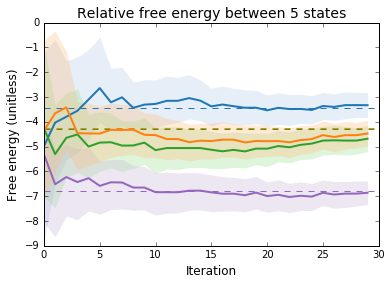

In [8]:
x = np.arange(map_estimate.shape[0])
for i in range(4):
    plt.plot(x, map_estimate[:,i], color=tableau4[i], lw=2)
    plt.axhline(y = f_true[i], color=tableau4[i], ls='--', lw=1)
    plt.fill_between(x, lowerq[:,i], upperq[:,i], facecolor=tableau4_light[i], linewidth=0, alpha=0.3, interpolate=True)
plt.title('Relative free energy between 5 states', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Free energy (unitless)', fontsize=12)
plt.show()